# <center> <img src="figs/LogoUFSCar.jpg" alt="Logo UFScar" width="110" align="left"/>  <br/> <center>Universidade Federal de São Carlos (UFSCar)<br/><font size="4"> Departamento de Computação, campus Sorocaba</center></font>
</p>

<font size="4"><center><b>Disciplina: Aprendizado de Máquina</b></center></font>
  
<font size="3"><center>Prof. Dr. Tiago A. Almeida</center></font>

## <center>Projeto Final</center>

**Nome**: Gabriel Araujo Streicher

**RA**: 822485


In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
## Carregar bibliotecas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scripts.preprocessamento import *
from scripts.analise_exploratoria import *
from scripts.experimentos import *
import os
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.metrics import roc_auc_score, roc_curve, auc, make_scorer
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score
from xgboost import XGBClassifier
from sklearn.impute import SimpleImputer
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import learning_curve

## Configurações de visualização
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

---
### Análise exploratória



Primeiro, vamos carregar os dados utilizando a classe DataLoader implementada em preprocessamento.py.
Depois vamos extrair as features das séries temporais e realizar um merge entre as features e as informações dos usuários para criar nosso dataframe.

In [3]:
## Carregar dados e extrair features
BASE_PATH = os.path.join('../')
dataLoader = DataLoader(base_path=BASE_PATH)


train_df, test_df, users_info, data_dict = dataLoader.load_data()
    
user_ids_train = train_df['Id'].unique()
user_ids_test = test_df['Id'].unique()
features_train_df = dataLoader.build_features_df(user_ids_train)
features_test_df = dataLoader.build_features_df(user_ids_test)

train_df = train_df.merge(features_train_df, on="Id", how="left")
train_df = train_df.merge(users_info, on="Id", how="left")

test_df = test_df.merge(features_test_df, on="Id", how="left")
test_df = test_df.merge(users_info, on="Id", how="left")

print('Dados carregados com sucesso.')

Dados carregados com sucesso.


In [ ]:
train_df.head()

Agora que nossos dados estão carregados, podemos análisá-los. Para começar vamos verificar a distribuição de alguns valores de informações do usuário.

In [ ]:
plot_distribuicoes_basicas(train_df)

tirar hifen

In [ ]:
sensor='EDA'
series_dict =dataLoader.get_average_series(train_df, sensor=sensor)
plot_series_grouped_by_label(series_dict, sensor=sensor)

In [ ]:
boxplot_sensor(train_df, col='ACC_1_mean')

Vamos tirar a direçao

In [ ]:
boxplot_sensor(train_df, col='ACC_2_mean')

outlier

In [ ]:
boxplot_sensor(train_df, col='TEMP_0_mean')

In [ ]:
# pega ids de quem tem temp acima de 100
high_temp_ids = train_df[train_df['TEMP_0_mean'] > 100]['Id'].unique()
display(high_temp_ids)

outlier

In [ ]:
boxplot_sensor(train_df, col='BVP_0_mean')

In [ ]:
boxplot_sensor(train_df, col='EDA_0_mean')

In [ ]:
boxplot_sensor(train_df, col='HR_0_mean')

In [ ]:
boxplot_sensor(train_df, col='IBI_1_mean')

In [ ]:
plot_sensor_by_label(train_df, BASE_PATH, dataLoader, sensor_name='TEMP.csv', samples_per_class=1)

---
### Pré-processamento

Nesta seção, as funções da etapa de pré-processamento dos dados devem ser implementadas e aplicadas (se necessário).

In [4]:
high_temp_ids = train_df[train_df['TEMP_0_mean'] > 100]['Id'].unique()
train_df.loc[train_df['Id'].isin(high_temp_ids), train_df.columns.str.startswith('TEMP')] = np.nan

high_temp_ids = test_df[test_df['TEMP_0_mean'] > 100]['Id'].unique()
test_df.loc[test_df['Id'].isin(high_temp_ids), test_df.columns.str.startswith('TEMP')] = np.nan

In [5]:
train_df = dataLoader.process_ACC(train_df, process_axis=True)
test_df = dataLoader.process_ACC(test_df, process_axis=True)

In [ ]:
train_df.head()

In [6]:
train_df = train_df.replace('-', np.nan)
test_df = test_df.replace('-', np.nan)

In [ ]:
train_df.info()

In [7]:
X, Y, test_df, le_target = encoder_imputer(train_df, test_df)

---
### Experimento

Nesta seção, o experimento deve ser conduzido, utilizando os protocolos experimentais padrões e testando diferentes modelos.

In [8]:
X_train, X_val, Y_train, Y_val = train_test_split(
    X, Y, test_size=0.2, random_state=42, stratify=Y
)

### k-vizinhos mais próximos

In [12]:
param_grid_knn = {
    'knn__n_neighbors': [3, 5, 7, 9, 11],
    'knn__weights': ['uniform', 'distance'],   
    'knn__p': [1, 2]                           
}


grid_knn = fit_kfold_grid_search('knn', KNeighborsClassifier(), param_grid_knn, X_train, Y_train, use_scaler=True)

Fitting 3 folds for each of 20 candidates, totalling 60 fits


In [13]:
grid_knn.fit(X_train, Y_train)
print(f"\nMelhores parâmetros: {grid_knn.best_params_}\n")
best_model_knn = grid_knn.best_estimator_

y_val_pred_proba = best_model_knn.predict_proba(X_val)
roc_auc_knn = roc_auc_score(pd.get_dummies(Y_val), y_val_pred_proba, multi_class='ovr')
print(f"AUC final no conjunto de validação: {roc_auc_knn:.4f}")

y_val_pred = best_model_knn.predict(X_val)
acc_knn = accuracy_score(Y_val, y_val_pred)
print(f"Acurácia no conjunto de validação: {acc_knn:.4f}")

Fitting 3 folds for each of 20 candidates, totalling 60 fits

Melhores parâmetros: {'knn__n_neighbors': 9, 'knn__p': 1, 'knn__weights': 'distance'}

AUC final no conjunto de validação: 0.8113
Acurácia no conjunto de validação: 0.6667


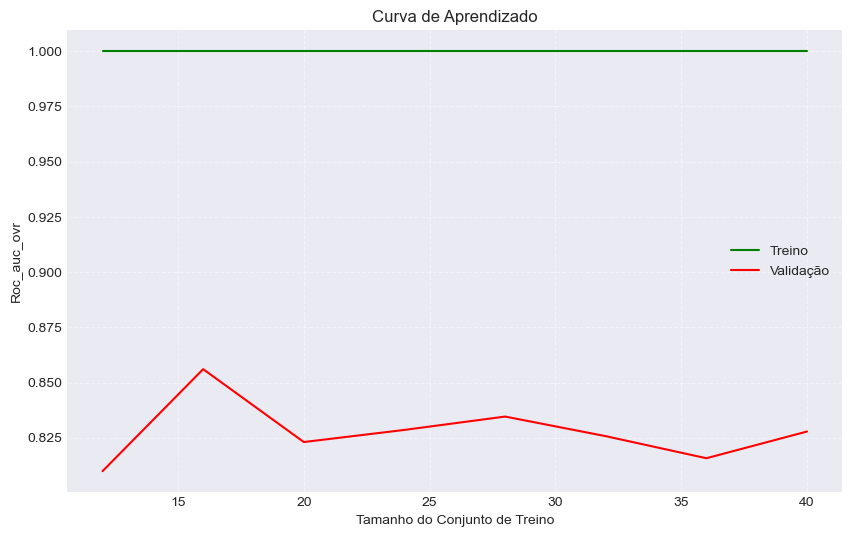

In [14]:
plot_learning_curve(best_model_knn, X_train, Y_train, scoring="roc_auc_ovr")

### Naive Bayes

In [ ]:
param_grid = {
    'nb__var_smoothing': [1e-9, 1e-8, 1e-7, 1e-6, 1e-5]                      
}

grid = fit_kfold_grid_search('nb', GaussianNB(), param_grid, X_train, Y_train, use_scaler=True)

In [ ]:
grid.fit(X_train, Y_train)
print(f"\nMelhores parâmetros: {grid.best_params_}\n")

best_model = grid.best_estimator_
y_val_pred_proba = best_model.predict_proba(X_val)
roc_auc = roc_auc_score(pd.get_dummies(Y_val), y_val_pred_proba, multi_class='ovr')
print(f"AUC final no conjunto de validação: {roc_auc:.4f}")
y_val_pred = best_model.predict(X_val)
acc = accuracy_score(Y_val, y_val_pred)
print(f"Acurácia no conjunto de validação: {acc:.4f}")

In [ ]:
plot_learning_curve(grid.best_estimator_, X_train, Y_train, scoring="accuracy")

### Regressão Logística

In [ ]:
param_grid = {
    'LogReg__C': [0.01, 0.1, 1, 10, 100],
    'LogReg__penalty': ['l2'],
    'LogReg__solver': ['lbfgs']  
}


grid = fit_kfold_grid_search('LogReg', LogisticRegression(), param_grid, X_train, Y_train, use_scaler=True)

In [ ]:
grid.fit(X_train, Y_train)
print(f"\nMelhores parâmetros: {grid.best_params_}\n")

best_model = grid.best_estimator_
y_val_pred_proba = best_model.predict_proba(X_val)
roc_auc = roc_auc_score(pd.get_dummies(Y_val), y_val_pred_proba, multi_class='ovr')
print(f"AUC final no conjunto de validação: {roc_auc:.4f}")
y_val_pred = best_model.predict(X_val)
acc = accuracy_score(Y_val, y_val_pred)
print(f"Acurácia no conjunto de validação: {acc:.4f}")

In [ ]:
plot_learning_curve(grid.best_estimator_, X_train, Y_train, scoring="accuracy")

#### Redes Neurais Artificiais

In [ ]:
param_grid = {
    'MLP__activation': ['relu', 'tanh'],
    'MLP__solver': ['adam', 'sgd'],
    'MLP__alpha': [0.0001, 0.001, 0.01]
}

grid = fit_kfold_grid_search('MLP', MLPClassifier(), param_grid, X_train, Y_train, use_scaler=True)

In [ ]:
grid.fit(X_train, Y_train)
print(f"\nMelhores parâmetros: {grid.best_params_}\n")

best_model = grid.best_estimator_
y_val_pred_proba = best_model.predict_proba(X_val)
roc_auc = roc_auc_score(pd.get_dummies(Y_val), y_val_pred_proba, multi_class='ovr')
print(f"AUC final no conjunto de validação: {roc_auc:.4f}")
y_val_pred = best_model.predict(X_val)
acc = accuracy_score(Y_val, y_val_pred)
print(f"Acurácia no conjunto de validação: {acc:.4f}")

In [ ]:
plot_learning_curve(grid.best_estimator_, X_train, Y_train, scoring="accuracy")

### SVM

In [ ]:
param_grid = {
    'svm__kernel': ['rbf'],          
    'svm__C': [0.1, 1, 10, 100],     
    'svm__gamma': ['scale', 0.1, 0.01, 0.001] 
}


grid = fit_kfold_grid_search('svm', SVC(probability=True, random_state=42), param_grid, X_train, Y_train, use_scaler=True)

In [ ]:
grid.fit(X_train, Y_train)
print(f"\nMelhores parâmetros: {grid.best_params_}\n")

best_model = grid.best_estimator_
y_val_pred_proba = best_model.predict_proba(X_val)
roc_auc = roc_auc_score(pd.get_dummies(Y_val), y_val_pred_proba, multi_class='ovr')
print(f"AUC final no conjunto de validação: {roc_auc:.4f}")
y_val_pred = best_model.predict(X_val)
acc = accuracy_score(Y_val, y_val_pred)
print(f"Acurácia no conjunto de validação: {acc:.4f}")

In [ ]:
plot_learning_curve(grid.best_estimator_, X_train, Y_train, scoring="accuracy")

### XGBoost


In [ ]:
param_grid = {
    'xgb__n_estimators': [50, 100, 150],     
    'xgb__max_depth': [2, 3, 4],            
    'xgb__learning_rate': [0.02, 0.05],      
    'xgb__subsample': [0.8],                 
    'xgb__colsample_bytree': [0.8],    
    'xgb__reg_lambda': [1, 2, 3],
    'xgb__reg_alpha': [0.5, 1],
}

grid = fit_kfold_grid_search('xgb', XGBClassifier(eval_metric='logloss', random_state=42, n_jobs=-1, verbosity=0), param_grid, X_train, Y_train, use_scaler=False, error_score=0.5)

In [ ]:
grid.fit(X_train, Y_train)
print(f"\nMelhores parâmetros: {grid.best_params_}\n")


best_model = grid.best_estimator_
y_val_pred_proba = best_model.predict_proba(X_val)
roc_auc = roc_auc_score(pd.get_dummies(Y_val), y_val_pred_proba, multi_class='ovr')
print(f"AUC final no conjunto de validação: {roc_auc:.4f}")
y_val_pred = best_model.predict(X_val)
acc = accuracy_score(Y_val, y_val_pred)
print(f"Acurácia no conjunto de validação: {acc:.4f}")

In [ ]:
best_params = grid.best_params_
print(best_params)

best_params_fixed = {k.replace("xgb__", ""): v for k, v in best_params.items()}

# Recria modelo XGBoost com verbose=1 para salvar logs
xgb_plot = XGBClassifier(
    **best_params_fixed,
    eval_metric="mlogloss",
    random_state=42,
)

# Treina com eval_set para registrar o histórico
xgb_plot.fit(
    X_train,
    Y_train,
    eval_set=[(X_train, Y_train), (X_val, Y_val)],
    verbose=False
)

# Histórico
evals = xgb_plot.evals_result()

train_logloss = evals["validation_0"]["mlogloss"]
val_logloss   = evals["validation_1"]["mlogloss"]

plt.figure(figsize=(10, 6))
plt.plot(train_logloss, label="Train Logloss", color='green')
plt.plot(val_logloss, label="Val Logloss", color='red')
plt.title("Learning Curve - Logloss (Treino vs Validação)")
plt.xlabel("Árvore")
plt.ylabel("Logloss")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

In [ ]:
from sklearn.metrics import roc_auc_score
import pandas as pd

train_auc_list = []
val_auc_list = []
d = {}

# Previsão incremental
for ntree in range(10, xgb_plot.n_estimators + 1):
    pred_train = xgb_plot.predict_proba(X_train, iteration_range=(0, ntree))
    pred_val   = xgb_plot.predict_proba(X_val,   iteration_range=(0, ntree))

    auc_train = roc_auc_score(pd.get_dummies(Y_train), pred_train, multi_class='ovr')
    auc_val   = roc_auc_score(pd.get_dummies(Y_val),   pred_val,   multi_class='ovr')

    d[ntree] = auc_val

    train_auc_list.append(auc_train)
    val_auc_list.append(auc_val)

trees_range = list(range(10, xgb_plot.n_estimators + 1))

plt.figure(figsize=(10, 6))
plt.plot(trees_range, train_auc_list, label="AUC Treino", color='green')
plt.plot(trees_range, val_auc_list, label="AUC Validação", color='blue')
plt.title("Curva de AUC (Treino vs Validação) por Número de Árvores")
plt.xlabel("Número de Árvores")
plt.ylabel("AUC")
plt.legend()
plt.grid(alpha=0.3)
plt.show()


In [ ]:
y_pred_val = best_model.predict_proba(X_val, iteration_range=(0, 22))
y_pred_train = best_model.predict_proba(X_train, iteration_range=(0, 22))
roc_auc_train = roc_auc_score(pd.get_dummies(Y_train), y_pred_train, multi_class='ovr')
roc_auc = roc_auc_score(pd.get_dummies(Y_val), y_pred_val, multi_class='ovr')
print(f"AUC final no conjunto de treino: {roc_auc_train:.4f}")
print(f"AUC final no conjunto de validação: {roc_auc:.4f}")

---
### Análise dos Resultados

Nesta seção, os resultados devem ser exibidos através de tabelas e gráficos, comparados e profundamente analisados.

---
### Salvar melhor resultado



In [ ]:
model = best_model
X_test = test_df[X.columns] 
probs_test = model.predict_proba(X_test, iteration_range=(0, 22))


# é sempre bom dar uma olhada no numero das classes certinho antes de salvar a submissão  
# (#print(le_target.classes_))
submission = pd.DataFrame({
    "Id": test_df["Id"],
    "Predicted_0": probs_test[:, 2],
    "Predicted_1": probs_test[:, 0],
    "Predicted_2": probs_test[:, 1],
})

submission.to_csv("submission.csv", index=False)